In [2]:
from numpy import *
from qutip  import *
from matplotlib.pyplot import *
import numpy as np
import qutip as qt
from qutip import *
import matplotlib.pyplot as plt

%matplotlib inline

In [3]:
def H_CPT(N,del_c, del_p, Omega_c, Omega_p, chi,kappa,Gamma,dephase):
    # Hamiltonian form is given by equation 7.3 from Novokov's thesis
    
    # del_x: detuning from the transitions
    # Omega_x: Rabi frequency for each transitions
    # chi is the dispersive shift, and note that the cavity freq difference when qubit is at |e> or |g> is 2*chi  
    # Qubit subspace: 2x2, Cavity subspace: N+1 x N+1
    g =basis(2,0)
    e = basis(2,1)
    
    term1 = -(del_c+2*chi)*tensor(g*g.dag(),num(N+1))
    term2 = -del_p*tensor(e*e.dag() ,qeye(N+1))-del_c *(tensor(e*e.dag(),num(N+1))-tensor(e*e.dag(),qeye(N+1)))
#     term3 = (Omega_c/2)*tensor(e*e.dag(),create(N+1))
    term4 = qt.tensor(qt.basis(2,1), qt.basis(N+1,1))*(tensor(qt.basis(2,0), qt.basis(N+1,0)).dag()) * Omega_p/2
#     H = term1 + term2 + term3 + term4 + (term3+term4).dag() 
    H = term1 + term2 + term4 + term4.dag() 
    A_cav   = tensor(qeye(2),destroy(N+1))*np.sqrt(kappa)
    A_relax   = tensor(destroy(2),qeye(N+1))*np.sqrt(Gamma)
    A_dephase = tensor( sigmaz(), qeye(N+1)) * np.sqrt(dephase)
    return H,[A_cav,A_relax,A_dephase]

In [4]:
def drive_pulse(t, args):  
    t_g = args['gate time']
    amp = args['amp']
    tau = t_g+100
    sigma = 100
    return amp * np.exp(-(t-tau)**2/(sigma**2)) 

In [21]:
N = 8
chi = -1* (2*np.pi) #dispersive shift
Omega_c = 10* (2*np.pi)
Omega_p = 10* (2*np.pi)

kappa = 7 * (2*np.pi)
Gamma = 0.1 * (2*np.pi)
dephase = 0.2 *(2*pi)

del_c = 0
del_control=0


g =basis(2,0)
e = basis(2,1)

H_0 ,c_ops = H_CPT(N,del_c,del_control, Omega_c, Omega_p, chi,kappa,Gamma,dephase)

H_d = [(Omega_c/2)*tensor(e*e.dag(),create(N+1)) +(Omega_c/2)*tensor(e*e.dag(),create(N+1)).dag() , drive_pulse]
H=[H_0,H_d]

Text(0.5, 0, 'Time')

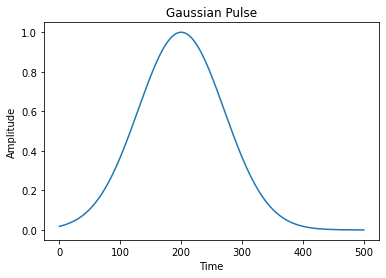

In [22]:
tg = 100
t_list = np.linspace(0,500,1000)  # 定义我们的演化时间
args1 = {}  #定义脉冲参数
args1['amp'] = 1  #这个值是随便选的
args1['gate time'] = tg


plt.plot(t_list, drive_pulse(t_list,args1))
plt.title('Gaussian Pulse')
plt.ylabel('Amplitude')
plt.xlabel('Time')

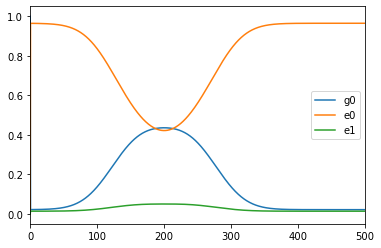

In [23]:
phi_0 = tensor(basis(2,0),basis(N+1,0)) # ground 是我们之前已经定义好了的
output = mesolve(H ,phi_0,t_list,c_ops=c_ops,args = args1)

state_g0 =qt.tensor(qt.basis(2,0), qt.basis(N+1,0))*qt.tensor(qt.basis(2,0), qt.basis(N+1,0)).dag()
state_e0 =qt.tensor(qt.basis(2,1), qt.basis(N+1,0))*qt.tensor(qt.basis(2,1), qt.basis(N+1,0)).dag()
state_e1 =qt.tensor(qt.basis(2,1), qt.basis(N+1,1))*qt.tensor(qt.basis(2,1), qt.basis(N+1,1)).dag()
state_trans =qt.tensor(qt.basis(2,1), qt.basis(N+1,1))*qt.tensor(qt.basis(2,1), qt.basis(N+1,0)).dag()

result_g0 = expect(state_g0, output.states)
result_e0 = expect(state_e0, output.states)
result_e1= expect(state_e1, output.states)
result_trans= expect(state_trans, output.states)




plt.plot(t_list,result_g0,label = 'g0')
plt.plot(t_list,result_e0,label = 'e0')
plt.plot(t_list,result_e1,label = 'e1')
#plt.plot(t_list,result_trans,label = 'trans')
plt.xlim([0,500])
plt.legend()